# Inverse scattering for circular billiard

## Importação das bibliotecas

In [1]:
import numpy as np
import scipy
import scipy.special as sc
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

## Lendo os dados

In [2]:
df = pd.read_csv('./data/dados.csv')

In [3]:
df

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
0,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.100000,0.100000,0.155397,...,0.001165,0.001162,0.001160,0.001158,0.001156,0.001154,0.001151,0.001149,0.001147,0.001145
1,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.110053,0.110053,0.218318,...,0.001668,0.001665,0.001662,0.001658,0.001655,0.001652,0.001649,0.001646,0.001642,0.001639
2,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.120106,0.120106,0.295887,...,0.002308,0.002303,0.002299,0.002294,0.002289,0.002285,0.002280,0.002276,0.002271,0.002267
3,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.130159,0.130159,0.389040,...,0.003100,0.003094,0.003088,0.003081,0.003075,0.003069,0.003062,0.003056,0.003050,0.003044
4,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.140212,0.140212,0.498437,...,0.004062,0.004053,0.004045,0.004036,0.004028,0.004019,0.004011,0.004003,0.003994,0.003986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.959788,1.959788,33.770915,...,7.209802,7.159769,7.108849,7.057510,7.006237,6.955518,6.905833,6.857639,6.811363,6.767387
186,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.969841,1.969841,33.874976,...,7.165885,7.113016,7.060545,7.008987,6.958838,6.910563,6.864583,6.821268,6.780927,6.743804
187,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.979894,1.979894,33.978737,...,7.114506,7.062327,7.011948,6.963834,6.918395,6.875980,6.836866,6.801264,6.769310,6.741074
188,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.989947,1.989947,34.082199,...,7.065322,7.017610,6.972949,6.931660,6.893986,6.860093,6.830073,6.803949,6.781680,6.763169


## Plot da scattering cross length para gamma, R = 2.0

In [4]:
row_gamma_R_2 = df[df['gamma'] == 2]

In [5]:
l_array = row_gamma_R_2.drop(columns=['M', 'HBAR', 'k_min', 'k_max', 'delta_k', 'n_min', 'n_max', 'gamma', 'R']).to_numpy()

In [6]:
l_array = l_array.transpose()

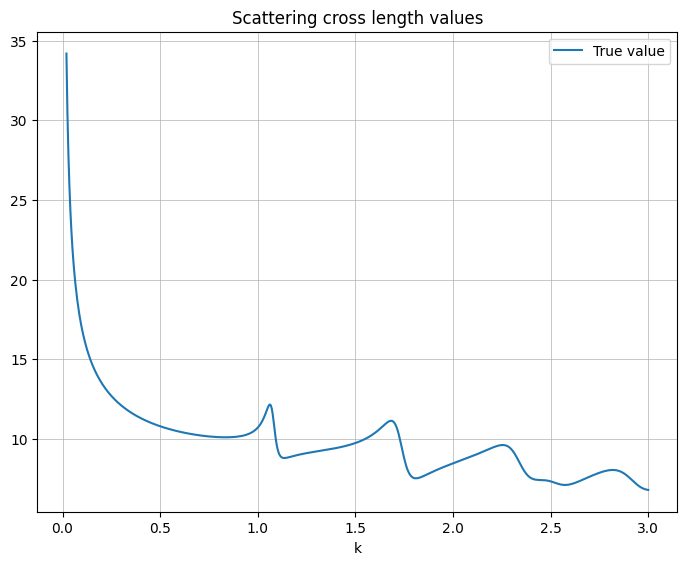

In [7]:
k_min = 0.02
k_max = 3.0
k = np.linspace(k_min, k_max, 596)

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array, ls='-', label="True value")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

## Implementação da rede neural

### Definição dos inputs da rede

In [8]:
features = df.drop(columns=['gamma', 'R'])

features = features.to_numpy()

In [9]:
targets = df[['gamma', 'R']]

targets = targets.to_numpy()

In [10]:
print(features.shape)
print(targets.shape)

(190, 603)
(190, 2)


### Definição da rede neural

A rede neural implementada é uma rede neural do tipo Multilayer Perceptron

In [11]:
def calculate_hidden_neurons(input_size, output_size):
    # Rule 1: The number of hidden neurons should be between the size of the input layer and the size of the output layer
    rule_1 = max(input_size, output_size)
    
    # Rule 2: The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer
    rule_2 = int(2/3 * input_size + output_size)
    
    # Rule 3: The number of hidden neurons should be less than twice the size of the input layer
    rule_3 = min(2 * input_size - 1, input_size + input_size // 3)
    
    # The number of hidden neurons should be the minimum that satisfies all rules, so will be the input size + 1/3*input_size
    hidden_neurons = int(input_size + input_size/3)

    print(hidden_neurons)
    return hidden_neurons

class CascadeCorrelationNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(CascadeCorrelationNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = nn.ModuleList()
        self.output_layer = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def add_hidden_layer(self):
        # Determine the size of the new hidden layer
        if len(self.hidden_layers) == 0:
            hidden_size = calculate_hidden_neurons(self.input_size, self.output_size)
            print('hidden_size if', hidden_size)
            new_layer = nn.Linear(self.input_size, hidden_size)
        else:
            prev_hidden_size = self.hidden_layers[-1].out_features
            hidden_size = calculate_hidden_neurons(self.input_size, self.output_size)
            print('hidden_size else', hidden_size)
            print('prev_hidden_size else', prev_hidden_size)
            new_layer = nn.Linear(self.input_size, hidden_size)
        self.hidden_layers.append(new_layer)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.sigmoid(layer(x))
            
        x = self.sigmoid(self.output_layer(x))
        return x

In [12]:
def train_cascade_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')



In [13]:
def evaluate_model(model, criterion, test_loader):
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader)}')

    return outputs

### Variáveis para o modelo, separação dos dados de teste e treino e etc

In [14]:
train, test_data = train_test_split(features, test_size = 0.2, random_state = 2)
real_train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 2)

train_target, test_target = train_test_split(targets, test_size = 0.2, random_state = 2)
real_train_target, validation_target = train_test_split(train_target, test_size = 0.3, random_state = 2)

input_size = 603
output_size = 2
batch_size = 100
num_epochs = 5000
learning_rate = 0.001

data_train = torch.tensor(real_train_data, dtype=torch.float32)
target_train = torch.tensor(real_train_target, dtype=torch.float32)

data_val = torch.tensor(validation_data, dtype=torch.float32)
target_val = torch.tensor(validation_target, dtype=torch.float32)

data_test = torch.tensor(test_data, dtype=torch.float32)
target_test = torch.tensor(test_target, dtype=torch.float32)

print("Input Shapes:")
print(data_train.shape, data_val.shape, data_test.shape)
print("Target Shapes:")
print(target_train.shape, target_val.shape, target_test.shape)

Input Shapes:
torch.Size([106, 603]) torch.Size([46, 603]) torch.Size([38, 603])
Target Shapes:
torch.Size([106, 2]) torch.Size([46, 2]) torch.Size([38, 2])


In [15]:
# Data Loaders
train_dataset = torch.utils.data.TensorDataset(data_train, target_train)
val_dataset = torch.utils.data.TensorDataset(data_val, target_val)
test_dataset = torch.utils.data.TensorDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
model = CascadeCorrelationNet(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_cascade_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(model, criterion, test_loader)

Epoch 1/5000, Training Loss: 0.21550389379262924, Validation Loss: 0.19004197418689728
Epoch 2/5000, Training Loss: 0.1764759123325348, Validation Loss: 0.1865496039390564
Epoch 3/5000, Training Loss: 0.34142719209194183, Validation Loss: 0.1817522943019867
Epoch 4/5000, Training Loss: 0.1536627635359764, Validation Loss: 0.17783309519290924
Epoch 5/5000, Training Loss: 0.11974064726382494, Validation Loss: 0.17273397743701935
Epoch 6/5000, Training Loss: 0.13299152441322803, Validation Loss: 0.17417366802692413
Epoch 7/5000, Training Loss: 0.23142947256565094, Validation Loss: 0.1708705574274063
Epoch 8/5000, Training Loss: 0.1279755774885416, Validation Loss: 0.16873811185359955
Epoch 9/5000, Training Loss: 0.13611702993512154, Validation Loss: 0.1678684502840042
Epoch 10/5000, Training Loss: 0.12144350819289684, Validation Loss: 0.16706137359142303
Epoch 11/5000, Training Loss: 0.11542588006705046, Validation Loss: 0.16621388494968414
Epoch 12/5000, Training Loss: 0.1566037498414516

tensor([[0.3203, 0.3245],
        [0.9989, 0.9989],
        [0.4503, 0.4570],
        [0.2033, 0.2069],
        [0.5768, 0.5845],
        [0.1696, 0.1733],
        [0.9621, 0.9645],
        [0.3861, 0.3915],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [0.2169, 0.2204],
        [0.2324, 0.2360],
        [1.0000, 1.0000],
        [0.1721, 0.1758],
        [0.1824, 0.1860],
        [0.3421, 0.3467],
        [0.6616, 0.6691],
        [0.7400, 0.7474],
        [0.6236, 0.6312],
        [1.0000, 1.0000],
        [0.5487, 0.5565],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [0.7502, 0.7575],
        [0.1973, 0.2009],
        [0.5392, 0.5470],
        [1.0000, 1.0000],
        [0.2244, 0.2280],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000],
        [0.9962, 0.9963]])

In [17]:
model.add_hidden_layer()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Reinitialize optimizer
train_cascade_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(model, criterion, test_loader)

804
hidden_size if 804


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x804 and 603x2)

In [ ]:
# predicted = output.squeeze().tolist()

In [ ]:
# predicted_labels = np.array(predicted)

In [ ]:
# predicted_labels.shape